## Centralized parameter server
This notebook shows a centralized parameter server. Discussion can be found in this issue: https://github.com/dask/dask-ml/issues/171

Currently, this notebook runs into a serialization issue with Torch models.

This notebook does have more advanced structure than the centralized example in https://gist.github.com/stsievert/ff8a1df9300a82f15a2704e913469522.

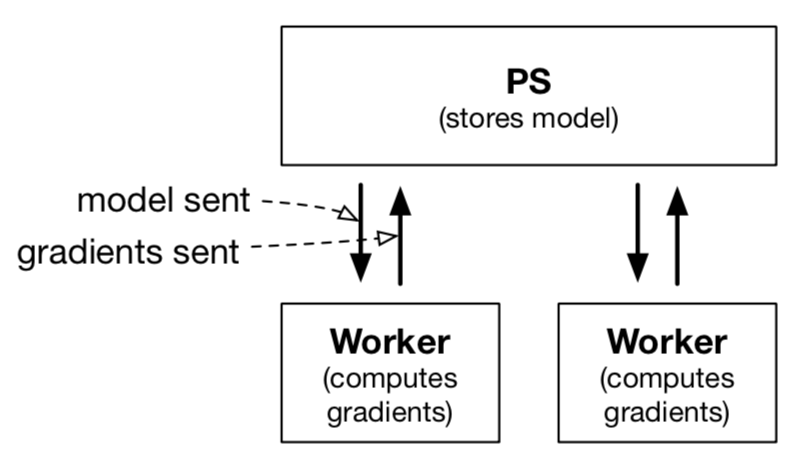

In [1]:
from IPython.display import Image
Image('imgs/centralized.png', width=400)

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np

import itertools
from time import sleep, time
import toolz
import numpy as np

In [4]:
import distributed
distributed.__version__, distributed.__file__

('1.23.0',
 '/Users/ssievert/Developer/dask/distributed/distributed/__init__.py')

### Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def num_params(model):
    param_sizes = [np.prod(tuple(p.size())) for p in model.parameters()]
    return sum(param_sizes)
    
#models = {num_params(model): model for model in models}

# ResNets are larger models; they range between 18 and 150ish layers with millions of parameters
import models

# These register_generic lines shouldn't be necessary; [1]
# defines a serialization scheme for torch.nn.Module, which
# every PyTorch model inherits from.
# [1]:https://github.com/mrocklin/distributed/blob/88045547f3978d028504f1caa9d1cbd1b5885c50/distributed/protocol/torch.py
#
# from distributed.protocol import register_generic
# register_generic(models.ResNet)
resnets = [models.resnet(layers=n) for n in [18, 34, 50, 101, 152]]

In [6]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Dask

In [7]:
from dask.distributed import Client, wait
client = Client()
client

Client Scheduler: tcp://127.0.0.1:50723 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


### Parameter Server


In [8]:
import torch.optim as optim
import copy

def clone(model):
    return copy.deepcopy(model)

class PS:
    model = None
    n_steps = 0

    def __init__(self, model, args, device, num_workers=1, max_iter=30):
        model = model.to(device)
        self.model = model
        self._model = clone(model)
        self.optimizer = optim.SGD(self._model.parameters(), lr=args.lr, momentum=args.momentum)
        self.n_steps = 0
        self._grads_recvd = 0
        self._updating = False
        self.max_iter = max_iter
        self.num_workers = num_workers
        self.start_time = time()
        
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)
        self.test_loader = test_loader

    def pull(self):
        """
        For a worker to pull a model from this PS
        """
        return self.model

    def push(self, grads, key=None):
        """
        For a worker to push some gradients to this PS
        """
        if grads:
            if self.n_steps is not None and self.n_steps > self.max_iter:
                self.n_steps = None
            if self.n_steps is None:
                return None
            if key != self.n_steps or self._updating:
                assert key < self.n_steps
                return self.n_steps
            
            assert not self._updating
            if self._grads_recvd == 0:
                self.optimizer.zero_grad()
            
            self._grads_recvd += 1
            self.aggregate(grads)
            if self._grads_recvd == self.num_workers:
                self._updating = True
                self._grads_recvd = 0
                self.step()
                self.n_steps += 1
                self._updating = False
            return self.n_steps

    def aggregate(self, grads):
        for name, param in self._model.named_parameters():
            if param.grad is None:
                param.grad = 0 * param
            param.grad += grads[name]
            
    def test(self, model, loader, device):
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        num = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                num += 1
                correct += predicted.eq(targets).sum().item()
        return {'step': self.n_steps, 
                'time': time() - self.start_time,
                'test_loss': test_loss / num,
                'test_acc': correct / total}

    def step(self):
        self.optimizer.step()
        if self.n_steps % 5 == 0:
            self.scores += [test(self.model, self.test_loader, self.device)]
                    
        self.model = clone(self._model)

# Execution

In [9]:
def train(model, device, data, target):
    model.train()
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    return model

In [10]:
import toolz
def worker(ps, device, train_loader, worker_id=0):
    meta = {'comm_grad': 0, 'comm_model': 0, 'comp_grad': 0,
            'n_comm_grad': 0, 'n_steps': 0,
            'worker_id': worker_id,
            'scores': []}
    last_step = -1
    step = 0
    train_loader = iter(train_loader)
    start_step = ps.push(None).result()
    
    loop_start = time()
    while True:
        if step != last_step:
            start = time()
            model = ps.pull().result()
            last_step = step
            meta['comm_model'] += time() - start
            meta['n_steps'] += 1
            
        start = time()
        data, target = next(train_loader)
        model = train(model, device, data, target)
        meta['comp_grad'] += time() - start
        
        if True:
            check = toolz.first(model.parameters())
            check = check.detach().numpy().flat[:3]
            print(step, check)
        
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        
        start = time()
        next_step = ps.push(grads, key=step).result()
        meta['n_comm_grad'] += 1
        meta['comm_grad'] += time() - start
        
        if step == next_step:
            sleep(10e-3)
            step = ps.n_steps
        else:
            step = next_step
        
        if step is None:
            break
            
    meta['avg_comm_grad'] = meta['comm_grad'] / meta['n_comm_grad']
    meta['avg_comp_grad'] = meta['comp_grad'] / meta['n_comm_grad']
    meta['avg_comm_model'] = meta['comm_model'] / meta['n_steps']
    meta['opt_time'] = time() - loop_start
    return meta

In [11]:
def test(model, batch_size=32, num_workers=4, iters=30, scaling='weak'):
    assert scaling in {'weak', 'strong'}
    if scaling == 'weak':
        batch_size //= num_workers
    n_params = [np.prod(list(p.size())) for p in model.parameters()]
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
    batch_size=1000, shuffle=True, **kwargs)
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_set = torchvision.datasets.CIFAR10('./data', train=True, download=False, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=batch_size,
                                              shuffle=True)
                                             #num_workers=1)
    #train_loader = torch.utils.data.DataLoader(
    #    datasets.MNIST('../data', train=True, download=True,
    #                   transform=transforms.Compose([
    #                       transforms.ToTensor(),
    #                       transforms.Normalize((0.1307,), (0.3081,))
    #                   ])),
    #    batch_size=batch_size, shuffle=True, **kwargs)

    device = torch.device("cuda" if use_cuda else "cpu")
    test_loader = None
    train_loader, test_loader, model = client.scatter([train_loader, test_loader, model])

    ps = client.submit(PS, model, args, device, 
                       max_iter=iters, num_workers=num_workers,
                       actor=True).result()
    
    futures = [client.submit(worker, ps, device, train_loader, worker_id=i)
               for i in range(num_workers)]
    metas = client.gather(futures)
    metas = [{'worker_batch_size': batch_size,
              'num_workers': num_workers,
              'iters': iters,
              'scaling': scaling,
              'params': sum(n_params),
              **m} for m in metas]
    return metas

In [14]:
num_workers = 4
# model = resnets[0]
model = Net()
# data = [test(model, num_workers=num_workers, iters=5, scaling='weak') 
#         for num_workers in [2, 4, 6]]
#         #for model in resnets[:3]]

In [15]:
print(type(model).mro())
test(model, num_workers=4)

[<class '__main__.Net'>, <class 'torch.nn.modules.module.Module'>, <class 'object'>]


distributed.core - ERROR - No dispatch for <class '__main__.Net'>
Traceback (most recent call last):
  File "/Users/ssievert/Developer/dask/distributed/distributed/core.py", line 340, in handle_comm
    result = yield result
  File "/Users/ssievert/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/Users/ssievert/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/Users/ssievert/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/Users/ssievert/Developer/dask/distributed/distributed/scheduler.py", line 2214, in scatter
    report=False)
  File "/Users/ssievert/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/Users/ssievert/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py"

Exception: No dispatch for <class '__main__.Net'>

In [53]:
import pandas as pd
df = pd.DataFrame(sum(data, []))
df.head()

,avg_comm_grad,avg_comm_model,avg_comp_grad,comm_grad,comm_model,comp_grad,iters,n_comm_grad,n_steps,num_workers,opt_time,params,scaling,worker_batch_size,worker_id
0,0.431208,0.424327,1.617879,4.312082,2.545961,16.178787,5,10,6,2,23.279888,11173962,weak,16,0
1,0.500862,0.428205,1.697454,4.507757,2.997432,15.277085,5,9,7,2,22.902149,11173962,weak,16,1
2,0.675556,0.764108,1.192803,8.106667,4.584646,14.313631,5,12,6,4,27.309265,11173962,weak,8,0
3,0.885406,1.089637,1.391538,7.083248,7.627456,11.132301,5,8,7,4,26.068309,11173962,weak,8,1
4,0.739191,0.703265,1.170361,8.131097,4.219589,12.873971,5,11,6,4,25.687755,11173962,weak,8,2


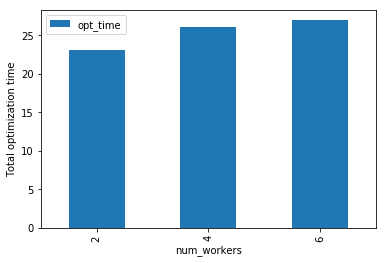

In [54]:
import matplotlib.pyplot as plt

show_var = 'params'
show_var = 'num_workers'
show = df.pivot_table(index=show_var, values='opt_time',
                      aggfunc=np.median)
show.plot.bar()
plt.ylabel('Total optimization time')
plt.savefig('total_opt_time.png', dpi=300)

In [55]:
r = df.groupby([show_var, 'worker_id'])['opt_time']
list(r)

[((2, 0), 0    23.279888
  Name: opt_time, dtype: float64), ((2, 1), 1    22.902149
  Name: opt_time, dtype: float64), ((4, 0), 2    27.309265
  Name: opt_time, dtype: float64), ((4, 1), 3    26.068309
  Name: opt_time, dtype: float64), ((4, 2), 4    25.687755
  Name: opt_time, dtype: float64), ((4, 3), 5    26.111374
  Name: opt_time, dtype: float64), ((6, 0), 6    30.799753
  Name: opt_time, dtype: float64), ((6, 1), 7    26.25958
  Name: opt_time, dtype: float64), ((6, 2), 8    26.862038
  Name: opt_time, dtype: float64), ((6, 3), 9    26.650819
  Name: opt_time, dtype: float64), ((6, 4), 10    26.952295
  Name: opt_time, dtype: float64), ((6, 5), 11    27.486288
  Name: opt_time, dtype: float64)]

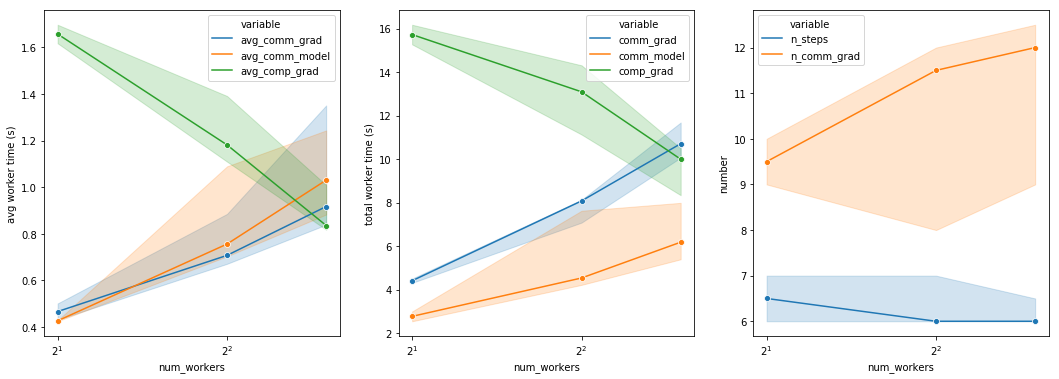

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = {'avg worker time (s)': ['avg_comm_grad', 'avg_comm_model', 'avg_comp_grad'],
             'total worker time (s)': ['comm_grad', 'comm_model', 'comp_grad'],
             'number': ['n_steps', 'n_comm_grad']}

w = 6
plt, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for (label, values), ax in zip(variables.items(), axs):
    show = df.melt(id_vars=[show_var], value_vars=values, value_name=label)
    sns.lineplot(data=show, x=show_var, hue='variable', y=label,
                 estimator=np.median, ax=ax, marker='o')
    if 'workers' in show_var:
        ax.set_xscale('log', basex=2)
plt.savefig('times.png', dpi=300)